<a href="https://www.kaggle.com/code/nikhilkushwaha2529/simple-gold-price-forecast-using-arima?scriptVersionId=156448731" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import numpy as np

import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
gold = pd.read_csv('../input/learn-time-series-forecasting-from-gold-price/gold_price_data.csv')
gold['Date'] = pd.to_datetime(gold['Date'], errors='coerce')
gold

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [3]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10787 non-null  datetime64[ns]
 1   Value   10787 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.7 KB


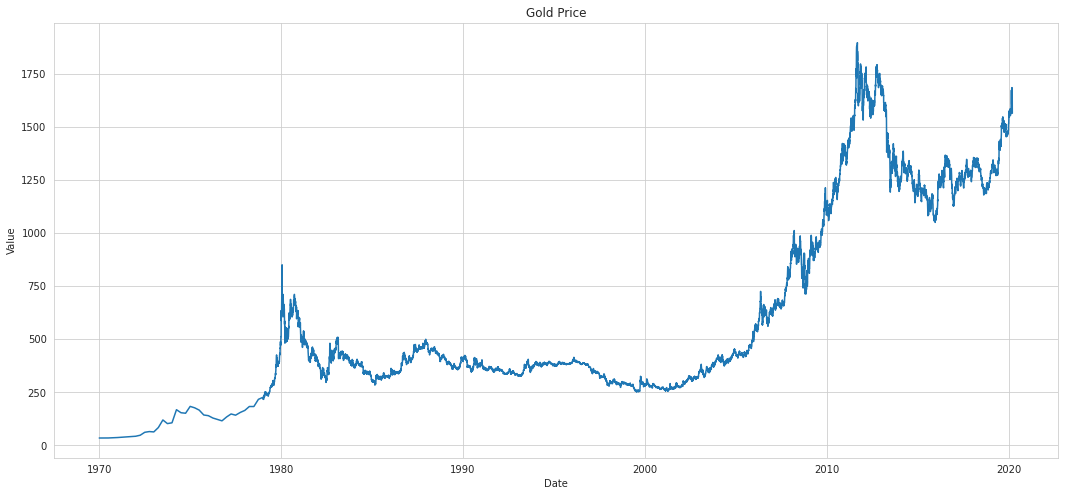

In [4]:
plt.figure(figsize = (18,8))
sns.lineplot(data=gold, x="Date", y="Value")
plt.title('Gold Price')
plt.show()

### See Time Series Components (Level, Trend, Seasonality)

In [5]:
gold_eda = gold.copy()
gold_eda.set_index('Date', inplace=True)

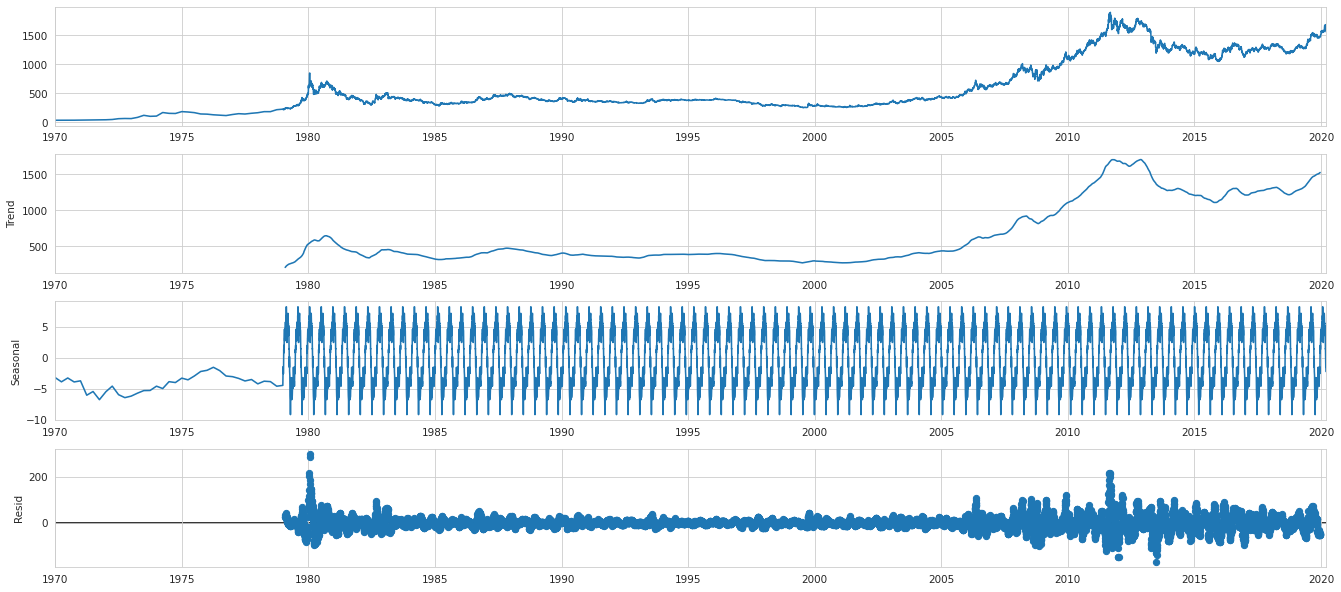

In [6]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_eda, model='additive', period=120)
result.plot()
plt.show()

### Data Splitting
- I decide to split data into 75:25

In [7]:
X_train = gold[:8090]
X_test = gold[8090:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (8090, 2)
X_test Shape (2697, 2)


### Forecasting For Nine Months Ahead

In [8]:
X_train = X_train[['Date', 'Value']]
X_test = X_test[['Date', 'Value']]

X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)

In [9]:
index_9_months = pd.date_range(X_test.index[-1], freq='MS', periods=9)
index_9_months

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

### Define d Using ADF Test
- pvalue = 0.05

In [10]:
def define_d(data):
    X_train = adfuller(data, autolag='AIC')
    adf = X_train[0]
    pvalue = X_train[1]
    critical_value = X_train[4]['5%']
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations', 'Critical Value']
    for value,label in zip(X_train,labels):
        print(label+' : '+str(value) )

    if (pvalue < 0.05):
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")

define_d(X_train)

ADF Test Statistic : 0.711139394130006
p-value : 0.9900575735401027
#Lags Used : 36
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Indicating It Is Non-Stationary **


In [11]:
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic : -15.695627256340012
p-value : 1.4163027798504891e-28
#Lags Used : 35
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Data Is Stationary **


    I define d = 1

### Define p and q using PACF and ACF plot

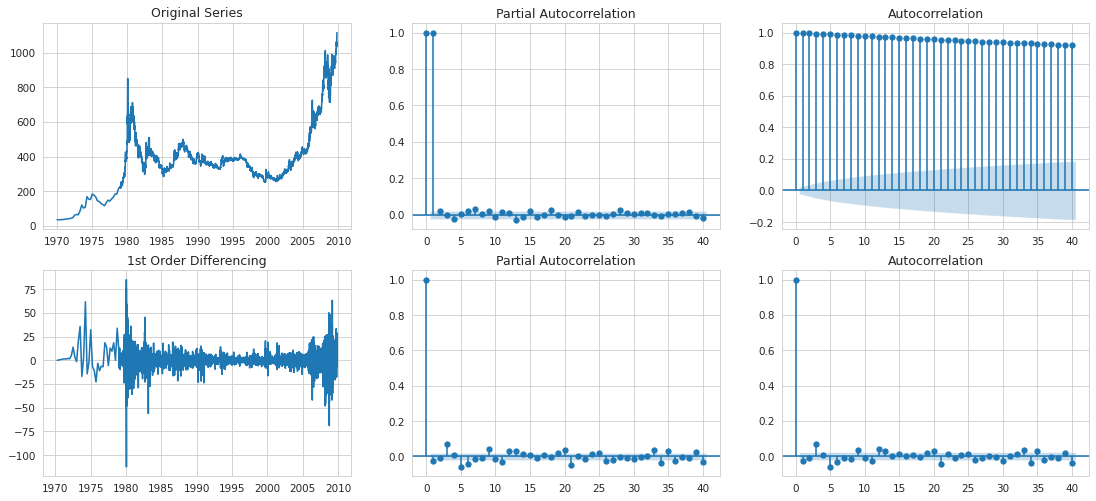

In [12]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(X_train); axes[0, 0].set_title('Original Series')
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(X_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show()

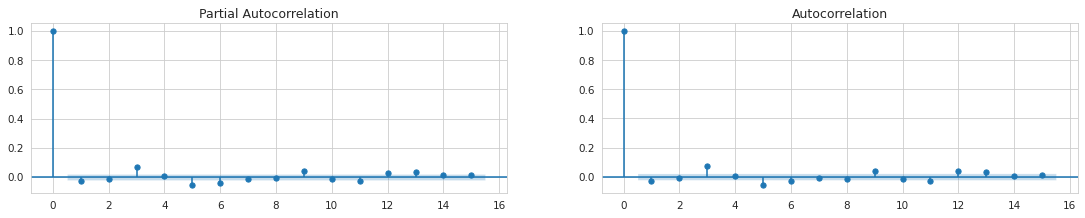

In [13]:
plt.rcParams.update({'figure.figsize':(18,3), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
plot_pacf(X_train.diff().dropna(), lags = 15, ax=ax[0])
plot_acf(X_train.diff().dropna(), lags = 15, ax=ax[1])
plt.show()

    Based on PACF and ACF, I define p = 0 and q = 0

### Build Model

In [14]:
gold_validate = gold['Value'][8090:]

#### Model 1

In [15]:
model_gold = ARIMA(X_train, order = (0, 1, 0))
gold_010 = model_gold.fit(disp=0)
print(gold_010.summary())

fc, se, conf = gold_010.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -26954.488
Method:                           css   S.D. of innovations              6.775
Date:                Mon, 25 Dec 2023   AIC                          53912.977
Time:                        15:19:03   BIC                          53926.973
Sample:                             1   HQIC                         53917.765
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1335      0.075      1.772      0.076      -0.014       0.281


{'Mean Absolute Percentage Error (%)': 12.26,
 'Root Mean Squared Error': 233.47932977267214}

#### Model 2

In [16]:
model_gold = ARIMA(X_train, order = (1, 1, 1))
gold_111 = model_gold.fit(disp=0)
print(gold_111.summary())

fc, se, conf = gold_111.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26951.423
Method:                       css-mle   S.D. of innovations              6.773
Date:                Mon, 25 Dec 2023   AIC                          53910.847
Time:                        15:19:06   BIC                          53938.840
Sample:                             1   HQIC                         53920.423
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1335      0.073      1.825      0.068      -0.010       0.277
ar.L1.D.Value     0.0448      0.165      0.271      0.786      -0.279       0.368
ma.L1.D.Value    -0.0723      0.164     

{'Mean Absolute Percentage Error (%)': 12.25,
 'Root Mean Squared Error': 233.55868267268346}

#### Model 3

In [17]:
model_gold = ARIMA(X_train, order = (1, 1, 0))
gold_110 = model_gold.fit(disp=0)
print(gold_110.summary())

fc, se, conf = gold_110.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -26951.520
Method:                       css-mle   S.D. of innovations              6.773
Date:                Mon, 25 Dec 2023   AIC                          53909.040
Time:                        15:19:07   BIC                          53930.034
Sample:                             1   HQIC                         53916.222
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1335      0.073      1.820      0.069      -0.010       0.277
ar.L1.D.Value    -0.0271      0.011     -2.437      0.015      -0.049      -0.005
                                    Root

{'Mean Absolute Percentage Error (%)': 12.25,
 'Root Mean Squared Error': 233.55400735215355}

#### Model 4

In [18]:
model_gold = ARIMA(X_train, order = (0, 1, 1))
gold_011 = model_gold.fit(disp=0)
print(gold_011.summary())

fc, se, conf = gold_011.forecast(2697, alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual))*100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return({'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse})

forecast_accuracy(fc, gold_validate.values)

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 8089
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -26951.461
Method:                       css-mle   S.D. of innovations              6.773
Date:                Mon, 25 Dec 2023   AIC                          53908.921
Time:                        15:19:07   BIC                          53929.916
Sample:                             1   HQIC                         53916.103
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1335      0.073      1.823      0.068      -0.010       0.277
ma.L1.D.Value    -0.0276      0.011     -2.467      0.014      -0.049      -0.006
                                    Root

{'Mean Absolute Percentage Error (%)': 12.25,
 'Root Mean Squared Error': 233.55609965419615}

    I decide to use Model 4 based on low MAPE score and low AIC score.

### Define Residual and Comparison Forecast Test

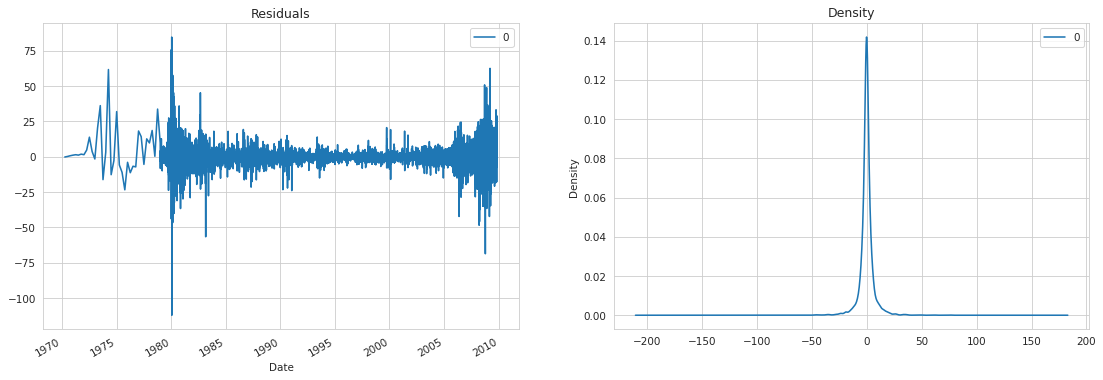

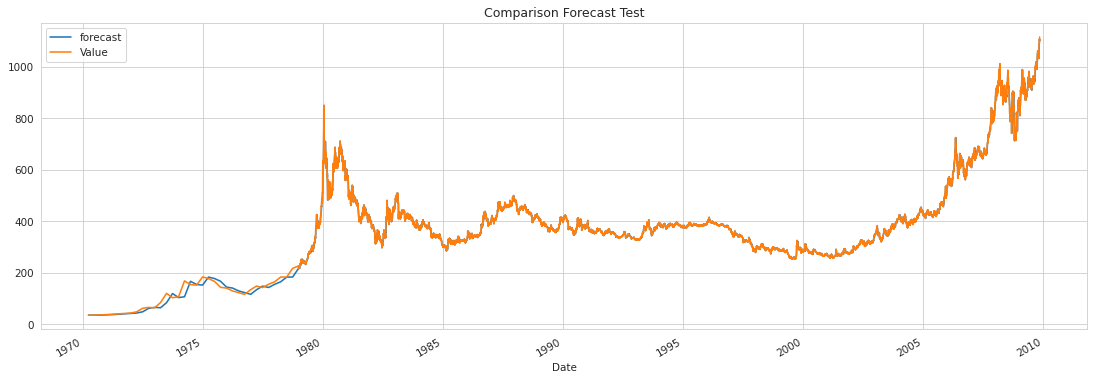

In [19]:
plt.rcParams.update({'figure.figsize':(18,6), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
residuals = pd.DataFrame(gold_011.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

gold_011.plot_predict(dynamic=False)
plt.title('Comparison Forecast Test', fontsize = 12)
plt.show()

The model looks good based on the 3 plots that shown. It means I can continue to do the forecast.

### Forecasting

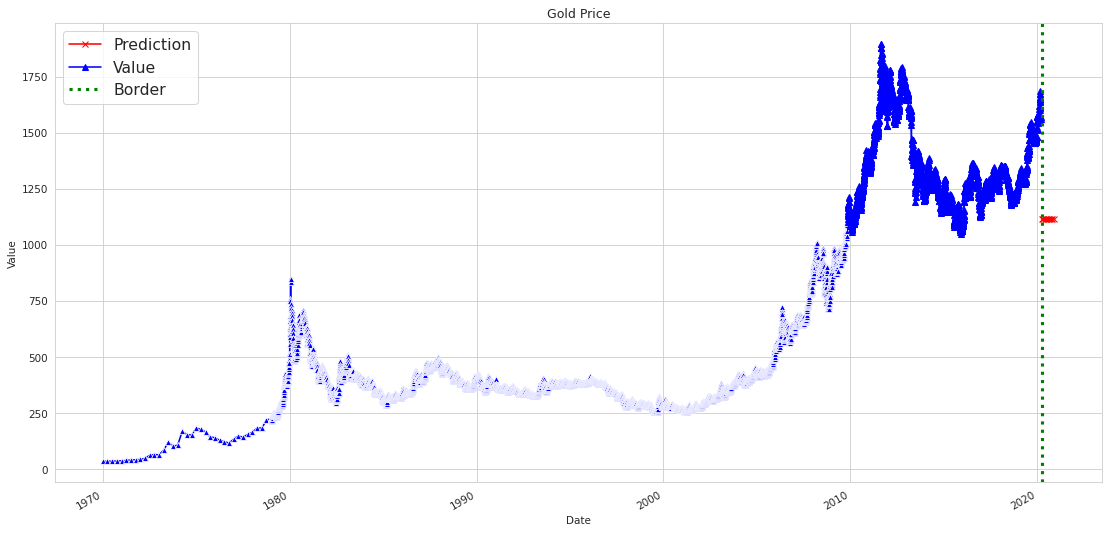

In [20]:
gold_forecast = gold_011.forecast(9)[0]
gold_forecast = pd.Series(gold_forecast, index=index_9_months)
gold_forecast = gold_forecast.rename("Prediction")

fig, ax = plt.subplots(figsize = (18, 9))
sns.lineplot(x = 'Date', y='Value', data=gold, color = 'blue', marker = '^')
gold_forecast.plot(ax = ax, c = 'red', marker = 'x', label = 'Prediction')
X_test.plot(ax = ax, c = 'blue', marker = '^')
plt.title('Gold Price')
ax.axvline(x = 18370, ls = ':', linewidth = 3, c = 'green', label = 'Border')
plt.legend(loc = 0, fontsize = 15)
plt.show()

In [21]:
gold_fcast = gold_forecast.to_frame()
gold_fcast.rename_axis("Date", inplace=True)
gold_fcast.reset_index(inplace=True)
gold_fcast

,Date,Prediction
0,2020-04-01,1115.011843
1,2020-05-01,1115.145317
2,2020-06-01,1115.278790
3,2020-07-01,1115.412264
4,2020-08-01,1115.545738
5,2020-09-01,1115.679211
6,2020-10-01,1115.812685
7,2020-11-01,1115.946158
8,2020-12-01,1116.079632


The forecasting result is shown above for 9 months ahead.  Hope it's useful. Thank you.